In [1]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_features_100samples_df, extract_noise

In [4]:
data_path = 'C:/Users/vpming/tuni_ml/data_7x7'
all_df = build_features_100samples_df(data_path)

In [5]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

dis_to_target
0    12000
1    12000
2    12000
3    12000
4    12000
5    12000
Name: count, dtype: int64


C:\Users\vpming\AppData\Local\Temp\ipykernel_8652\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


In [6]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [7]:
x_tt = np.stack(df['time_trace'])
x_c = df[['cMax', 'cVariance']].values

x = np.hstack([x_tt, x_c])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3, 4, 5
n_bins = 6
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3,4,5

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [8]:
class MLP(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [9]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [12]:
def fit(model, train_loader, test_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/mlp_cmax_cvar_tt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/50 Train Loss: 1.1044  Train Accuracy: 49.44%  Test Loss: 1.1500  Test Accuracy: 47.37%
Epoch 10/50 Train Loss: 1.0480  Train Accuracy: 52.41%  Test Loss: 1.1875  Test Accuracy: 46.94%
Epoch 15/50 Train Loss: 0.9958  Train Accuracy: 54.87%  Test Loss: 1.2176  Test Accuracy: 46.67%
Epoch 20/50 Train Loss: 0.9501  Train Accuracy: 57.33%  Test Loss: 1.2979  Test Accuracy: 46.66%
Epoch 25/50 Train Loss: 0.9039  Train Accuracy: 59.47%  Test Loss: 1.3756  Test Accuracy: 46.47%
Epoch 30/50 Train Loss: 0.8736  Train Accuracy: 61.30%  Test Loss: 1.4631  Test Accuracy: 45.40%
Epoch 35/50 Train Loss: 0.8371  Train Accuracy: 62.78%  Test Loss: 1.5641  Test Accuracy: 45.09%
Epoch 40/50 Train Loss: 0.8116  Train Accuracy: 64.09%  Test Loss: 1.6472  Test Accuracy: 45.31%
Epoch 45/50 Train Loss: 0.7870  Train Accuracy: 65.14%  Test Loss: 1.7482  Test Accuracy: 45.35%
Epoch 50/50 Train Loss: 0.7644  Train Accuracy: 66.15%  Test Loss: 1.8406  Test Accuracy: 44.81%


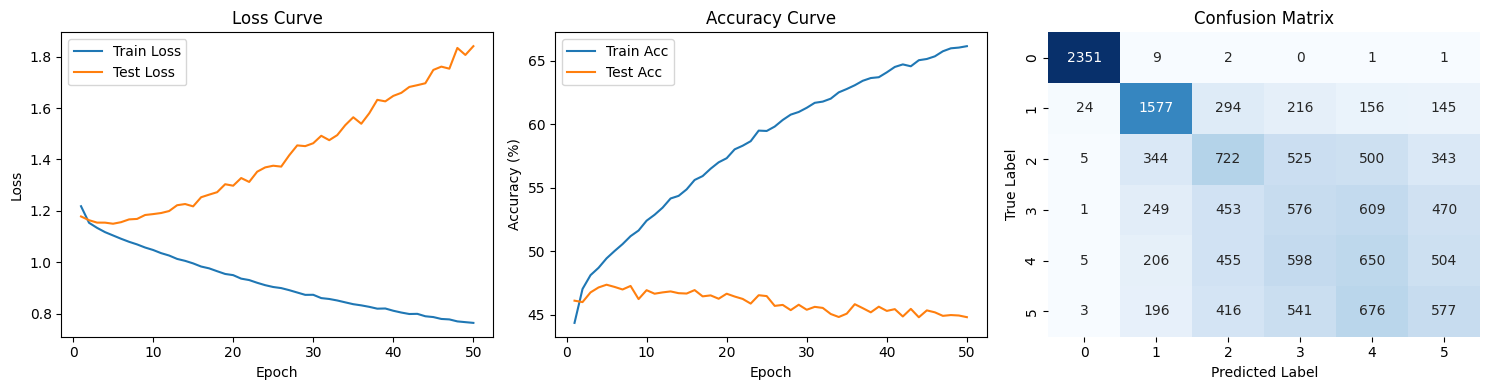

([1.2180825134780673,
  1.1536569741699432,
  1.134012408455213,
  1.1173306926091513,
  1.104426863193512,
  1.0915512495570712,
  1.079744077987141,
  1.0695752770370908,
  1.0575056271420584,
  1.047956670390235,
  1.0356628349754546,
  1.026369630959299,
  1.013203496866756,
  1.0056288211213218,
  0.9957815027236938,
  0.9835285011927287,
  0.9764626701672872,
  0.9653315762678782,
  0.9546760586897532,
  0.9501072949171067,
  0.9364572597874535,
  0.930928783747885,
  0.9203409009509617,
  0.9110450743304359,
  0.903929225537512,
  0.8996946166621315,
  0.8916596690813701,
  0.882533503903283,
  0.8733818153540294,
  0.8736298571692572,
  0.8608120404349433,
  0.8573744150002798,
  0.8515406651629343,
  0.8442333191302087,
  0.8370900036891301,
  0.8325382843944762,
  0.8267593442400296,
  0.8196737174855339,
  0.8203675329685212,
  0.8115720716449949,
  0.8046092657910453,
  0.798921568526162,
  0.7995457248224153,
  0.7901399325993326,
  0.7869962788290448,
  0.7796810889575216

In [13]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = MLP(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12015 samples; Testing on 3004 samples
Epoch 5/15 Train Loss: 0.8235  Train Accuracy: 62.26%  Test Loss: 0.9558  Test Accuracy: 54.49%
Epoch 10/15 Train Loss: 0.6317  Train Accuracy: 72.86%  Test Loss: 1.1793  Test Accuracy: 52.60%
Epoch 15/15 Train Loss: 0.4232  Train Accuracy: 83.80%  Test Loss: 1.5708  Test Accuracy: 53.33%


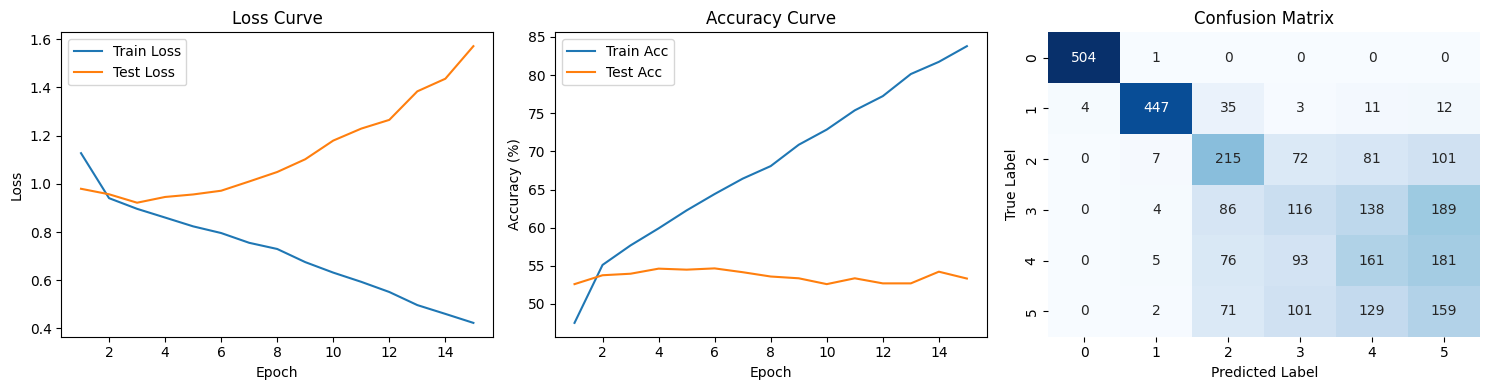


=== Training for noise 0.02 ===
Training on 12056 samples; Testing on 3015 samples
Epoch 5/15 Train Loss: 0.9914  Train Accuracy: 55.61%  Test Loss: 1.1024  Test Accuracy: 48.79%
Epoch 10/15 Train Loss: 0.7970  Train Accuracy: 67.10%  Test Loss: 1.2822  Test Accuracy: 48.36%
Epoch 15/15 Train Loss: 0.5468  Train Accuracy: 78.73%  Test Loss: 1.6528  Test Accuracy: 47.79%


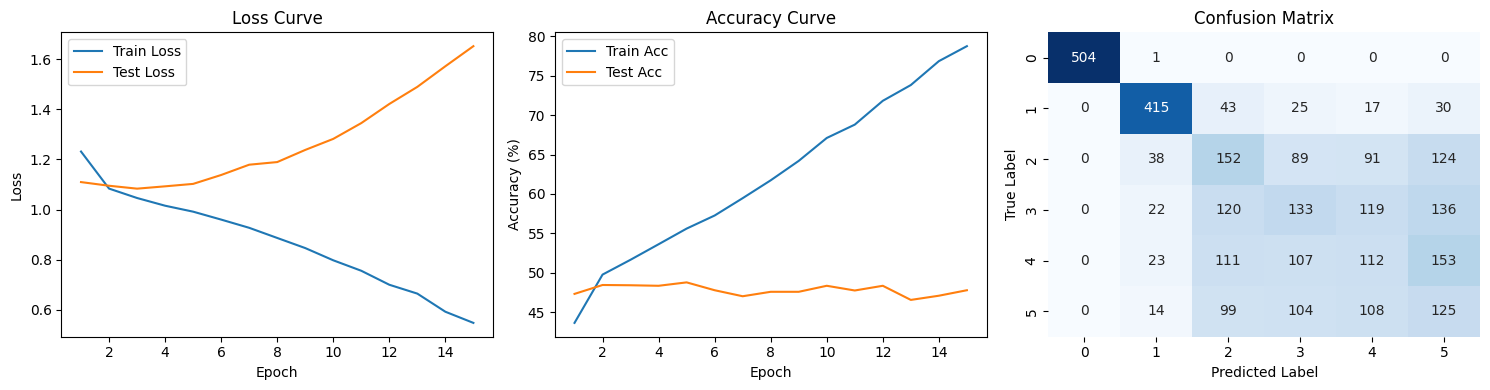


=== Training for noise 0.03 ===
Training on 12132 samples; Testing on 3033 samples
Epoch 5/15 Train Loss: 1.0810  Train Accuracy: 53.50%  Test Loss: 1.1918  Test Accuracy: 45.47%
Epoch 10/15 Train Loss: 0.8927  Train Accuracy: 62.94%  Test Loss: 1.3658  Test Accuracy: 44.64%
Epoch 15/15 Train Loss: 0.6555  Train Accuracy: 74.10%  Test Loss: 1.6871  Test Accuracy: 43.26%


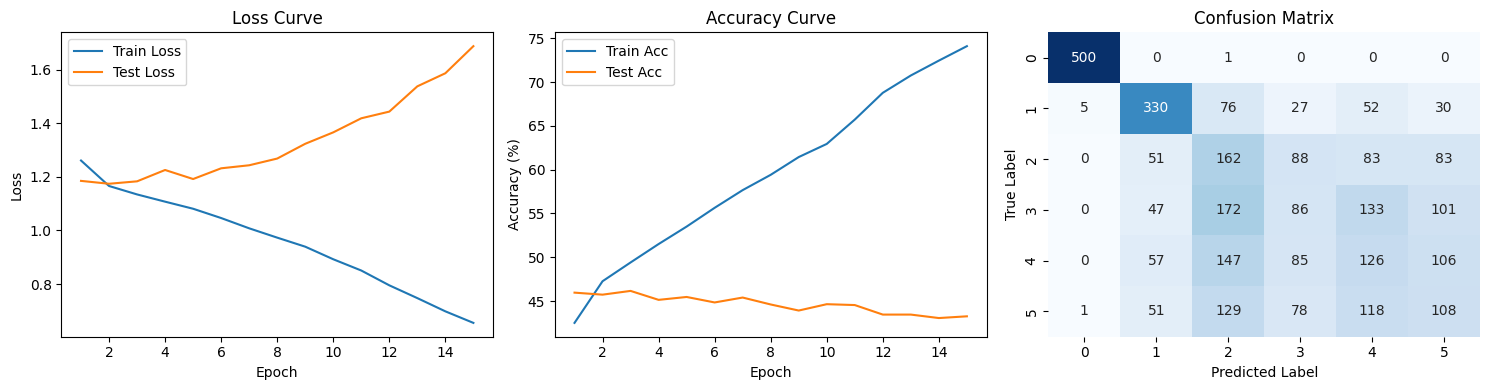


=== Training for noise 0.04 ===
Training on 11863 samples; Testing on 2966 samples
Epoch 5/15 Train Loss: 1.1443  Train Accuracy: 50.72%  Test Loss: 1.2567  Test Accuracy: 44.37%
Epoch 10/15 Train Loss: 0.9520  Train Accuracy: 60.88%  Test Loss: 1.4133  Test Accuracy: 42.25%
Epoch 15/15 Train Loss: 0.7163  Train Accuracy: 72.01%  Test Loss: 1.7984  Test Accuracy: 41.74%


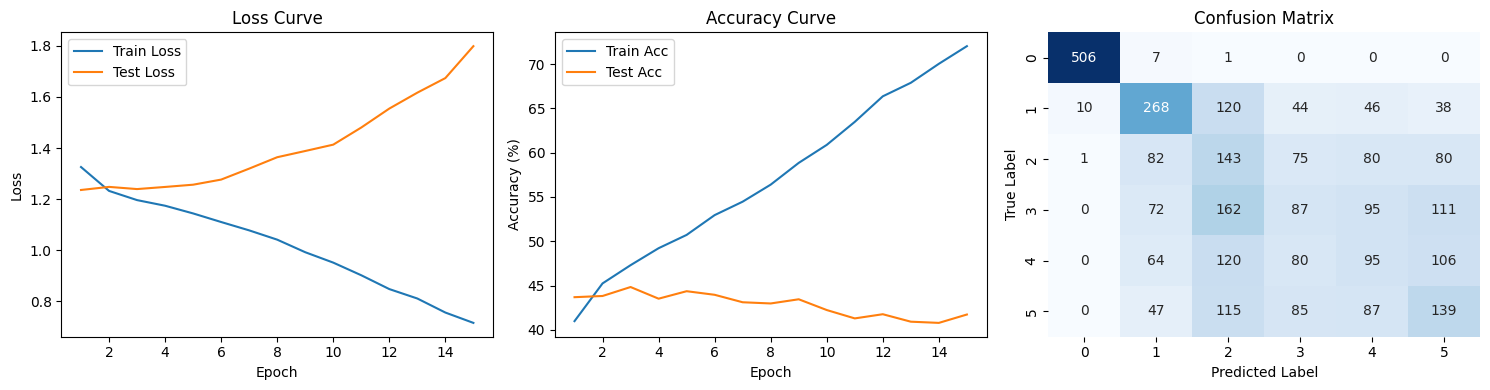


=== Training for noise 0.05 ===
Training on 9532 samples; Testing on 2384 samples
Epoch 5/15 Train Loss: 1.1776  Train Accuracy: 49.62%  Test Loss: 1.3409  Test Accuracy: 41.57%
Epoch 10/15 Train Loss: 0.9885  Train Accuracy: 60.19%  Test Loss: 1.5057  Test Accuracy: 40.39%
Epoch 15/15 Train Loss: 0.7498  Train Accuracy: 71.32%  Test Loss: 1.8274  Test Accuracy: 39.51%


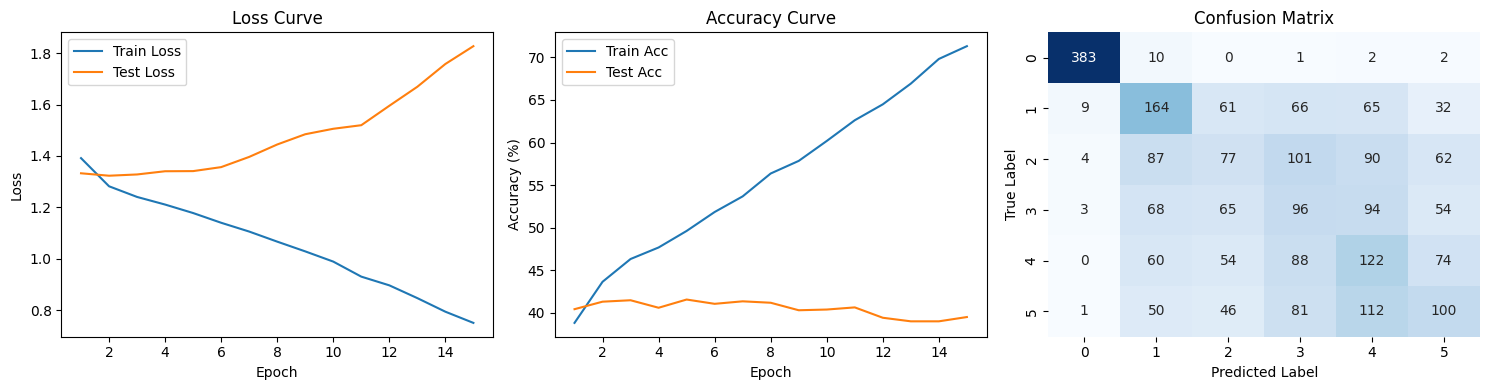

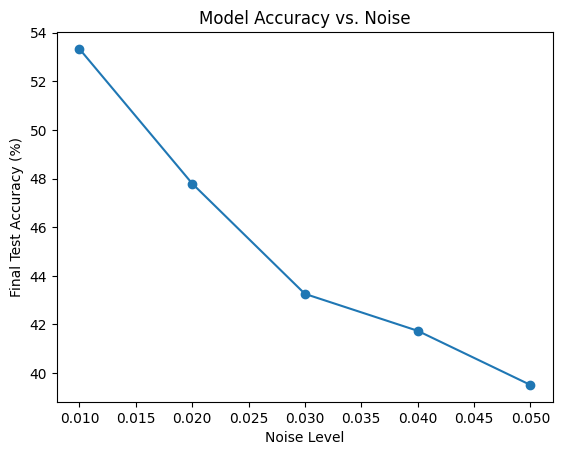

In [14]:
results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    
    x_tt = np.stack(df.loc[mask, 'time_trace'])
    x_c = df.loc[mask, ['cMax','cVariance']].values            # shape (n_samples_for_noise, 2)
    X = np.hstack([x_tt, x_c])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 6
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = MLP(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise") 
plt.show()